# Log

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
base_path = './results/attunet-seg2/'

train_loss = []
val_loss = []
val_epochs = []

for i in range(100):
    
    f_path = os.path.join(base_path, f'version_{i}', 'metrics.csv')
    
    try:
        metrics = pd.read_csv(f_path)
        
        t_loss = np.array(metrics['train_loss'])
        v_loss = np.array(metrics['val_loss'])
        ep = np.array(metrics['epoch'])
        
        t_idxs = ~np.isnan(t_loss)
        v_idxs = ~np.isnan(v_loss)        
    
        train_loss.append(t_loss[t_idxs])
        val_loss.append(v_loss[v_idxs])
        
        if len(val_epochs) == 0:
            val_epochs.append(ep[v_idxs])
        else:
            shift = val_epochs[-1][-1] + 1
            val_epochs.append(ep[v_idxs] + shift)
    
    except:
        break

train_loss = np.concatenate(train_loss)
val_loss = np.concatenate(val_loss)
val_epochs = np.concatenate(val_epochs)

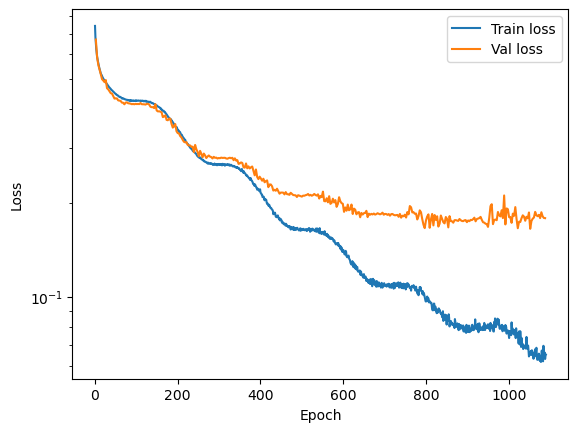

In [3]:
plt.plot(train_loss, label='Train loss')
plt.plot(val_epochs, val_loss, label='Val loss')

plt.yscale('log')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate MAE

In [16]:
import matplotlib.pyplot as plt

import torch

from dataset import MAEHeartDataset
from att_unet import AttUNet


In [103]:
ckpt_path = './results/attunet-mae/version_0/checkpoints/best-epoch=00065.ckpt'
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AttUNet.load_from_checkpoint(ckpt_path)
model.to(device=device)
model.eval()

print("Model loaded to", device)

Model loaded to cpu


In [104]:
vid_path = '../../../../../../../data/project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_04_C11440_30s4.avi'
dataset = MAEHeartDataset(vid_path, n_frames=500, balance=True, augment=False, seed=0)


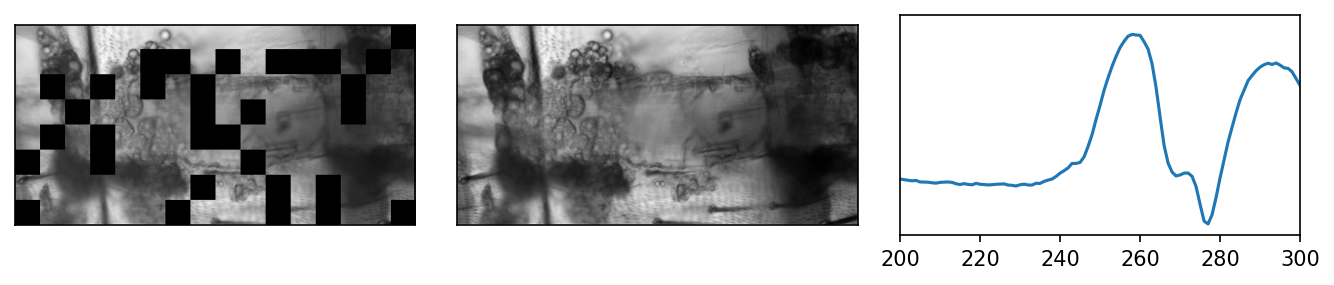

In [105]:
img, mask = dataset.get_by_frame(100)

fig, ax = plt.subplots(1, 3, figsize=(9,2), dpi=150)

img = img[1:2, :, :]
masked_img = img.clone().detach()
masked_img[mask] = 0

ax[0].imshow(masked_img[0], cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img[0], cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].plot(dataset.mses)
ax[2].set_yticks([])
# ax[2].set_xlim(200, 300)

plt.tight_layout()

In [106]:
img, mask = dataset.get_by_frame(260)

input_img = img.clone().to(device=device)
input_img = input_img[None, :, :, :]

input_img[0, 1:2, :, :][mask] = -1
# input_img[torch.tile(mask, (1, 3, 1, 1))] = -1

pred = model(input_img)

pred = pred.detach().cpu()[0, :, :, :]

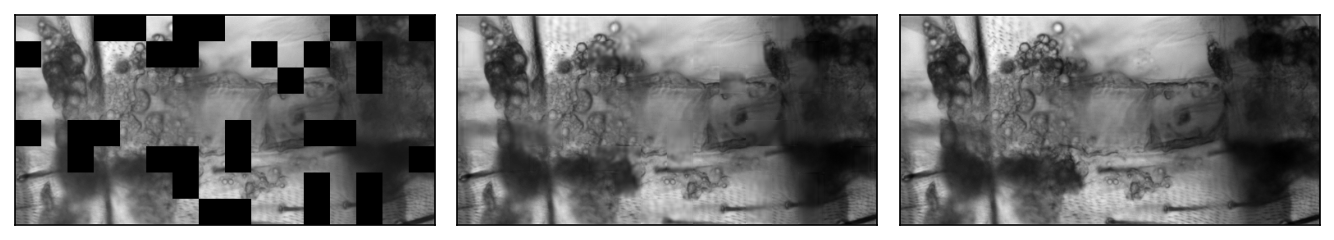

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(9,4), dpi=150)

img = img[1:2, :, :]
masked_img = img.clone().detach()
masked_img[mask] = 0

# pred = (pred - pred.min()) / (pred.max() - pred.min())  
pred = torch.clamp(pred, 0, 1)

vis_pred = img.clone().detach()
vis_pred[mask] = pred[mask]

ax[0].imshow(masked_img[0], cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])

subplt = ax[1].imshow(vis_pred[0], cmap='gray')
# plt.colorbar(subplt,ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(img[0], cmap='gray')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()
plt.show()

# Evaluate SEG

In [83]:
import matplotlib.pyplot as plt

import torch

from dataset import SEGHeartDataset
from att_unet import AttUNet


In [108]:
ckpt_path = './results/attunet-seg2/version_0/checkpoints/best-epoch=01052.ckpt'

model = AttUNet.load_from_checkpoint(ckpt_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)
model.eval()

print("Model loaded to", device)

Model loaded to cpu


In [126]:
vid_path = '../../../../../../project/Drosophila_MelkaniLab/SHARED_VIDEOS/machine_learning/training/task_cs_1wm_06_c11440_30s-control7.avi-2021_12_26_08_41_16-camvid 1.0'
dataset = SEGHeartDataset(vid_path, n_frames=500, balance=True, augment=False, seed=0)


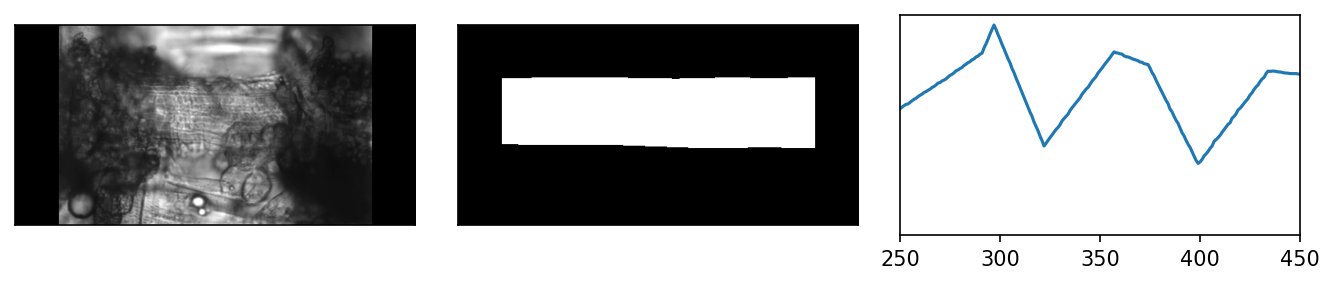

In [132]:
img, mask = dataset.get_by_frame(0)

fig, ax = plt.subplots(1, 3, figsize=(9,2), dpi=150)

img = img[1:2, :, :]

ax[0].imshow(img[0], cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(mask[0], cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].plot(dataset.diams)
ax[2].set_yticks([])
# ax[2].set_xlim(250, 450)


plt.tight_layout()

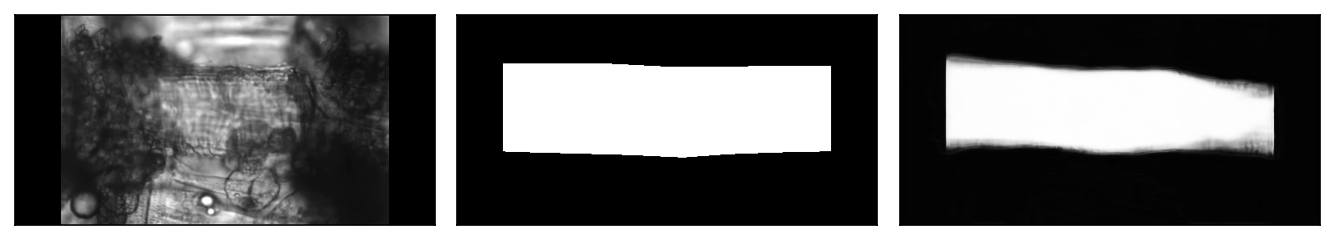

In [131]:
img, mask = dataset.get_by_frame(300)

input_img = img.clone().to(device=device)
input_img = input_img[None, :, :, :]

pred = model(input_img)
pred = pred.detach().cpu()[0, :, :, :]
pred = torch.sigmoid(pred)

fig, ax = plt.subplots(1, 3, figsize=(9,4), dpi=150)

img = img[1:2, :, :]

# pred = (pred > 0.35)

ax[0].imshow(img[0], cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])

subplt = ax[1].imshow(mask[0], cmap='gray')
# plt.colorbar(subplt,ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(pred[0], cmap='gray', vmin=0, vmax=1)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()
plt.show()

In [116]:
pred.min(), pred.max()

(tensor(0.0021), tensor(0.9943))